In [14]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #for visualization
import torch
import torch.nn as nn
from mpl_toolkits.axes_grid1 import make_axes_locatable
np.random.seed(1)
torch.manual_seed(1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [15]:
### Instructions for the students using Google Colab
### If you are using Google Colab, you will need to first mount the google drive. You can do this by running the following code after uncommenting it.
#from google.colab import drive
#drive.mount('/content/drive', force_remount=False)

### You also need to upload the data to your Google drive.
### Make sure you are using the same google account for both Google Colab and Google Drive.

### For example, if the dataset data.npy is located in /content/drive/My Drive/CME216/HW5/PartA, then you can use the following code to load the data.
# data_path = '/content/drive/MyDrive/CME216/HW5/PartA'
# data = np.load(f'{data_path}/data.npy')
### OR else.....
### you can cd to the directory where the data is located using the following command
# %cd /content/drive/MyDrive/CME216/HW5/PartA
### And then load the data. Make sure that the notebook is running in the same directory where the data is located.
# data = np.load('data.npy')

## Q1: Data wrangling

In [16]:
# load data
from torch.utils.data import TensorDataset, DataLoader

X = np.load("u0_data.npy")
Y = np.load("uT_data.npy")

# split data into training, validation and test sets
X_flatten = X.reshape(len(X), -1)
Y_flatten = Y.reshape(len(Y), -1)

train_split, val_split = int(len(X)*0.8), int(len(X)*0.9)
X_train, X_test, X_validation = X_flatten[:train_split], X_flatten[train_split:val_split], X_flatten[val_split:]
Y_train, Y_test, Y_validation = Y_flatten[:train_split], Y_flatten[train_split:val_split], Y_flatten[val_split:]

# create corresponding PyTorch tensors
print(X_flatten.dtype)
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train))
validation_dataset = TensorDataset(torch.from_numpy(X_validation), torch.from_numpy(Y_validation))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test))

# create Pytorch dataloaders
train_loader = DataLoader(train_dataset)
validation_loader = DataLoader(validation_dataset)
test_loader = DataLoader(test_dataset,shuffle=True)


float64


## Q2: Model construction

In [17]:
# Define a simple fully connected network class with following arguments:
# input_dim: input dimension
# output_dim: output dimension
# n_layers: number of layers (counted as number of hidden layers + 1 output layer)
# n_units: number of neurons in each layer
# activation: type of activation function (NOTE: there should be no activation function in the output layer)

class FullyConnectedNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, n_layers, n_units, activation):
        super(FullyConnectedNetwork, self).__init__()  #we create a temporaty object of superclass(parent class), and then call the constructor to initialize 
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(input_dim,n_units))
        for _ in range( n_layers-1):
            self.layers.append(torch.nn.Linear(n_units,n_units))
        self.layers.append(torch.nn.Linear(n_units,output_dim))
        self.act = activation
    
    def forward(self, x):
        for layer in self.layers[:-1]:  #no activation in last layers
            x = self.act(layer(x))
        x = self.layers[-1](x)
        return x


## Helper functions
You may use the following functions in train_and_plot function below

In [18]:
# function to compute relative L2 error in percentage
def rel_l2_error(pred, true):
    """A helper function to compute the relative L2 error in percentage

    Args:
        pred (torch.Tensor): Predicted values
        true (torch.Tensor): True values

    Returns:
        torch.Tensor: Relative L2 error in percentage
    """
    return (torch.norm(pred - true) / torch.norm(true))*100


# prediction plotting function
def prediction_plots(n_plots, indices, u0, uT, output):
    """A helper function to plot the predictions of the model

    Args:
        n_plots (int): Number of plots to display
        indices (list): List of indices to plot
        u0 (np.array): Initial condition (3D numpy array of shape (n_samples, D, D))
        uT (np.array): Target condition (3D numpy array of shape (n_samples, D, D))
        output (np.array): Model output (3D numpy array of shape (n_samples, D, D))
    """
    fig, axs = plt.subplots(n_plots, 4, figsize=(20, 5*n_plots))
    for i, idx in enumerate(indices):
        im = axs[i, 0].imshow(u0[idx, :, :], cmap='viridis')
        divider = make_axes_locatable(axs[i, 0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        im = axs[i, 1].imshow(uT[idx, :, :], cmap='viridis')
        divider = make_axes_locatable(axs[i, 1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        im = axs[i, 2].imshow(output[idx, :, :], cmap='viridis')
        divider = make_axes_locatable(axs[i, 2])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        im = axs[i, 3].imshow(output[idx, :, :]-uT[idx, :, :], cmap='viridis')
        divider = make_axes_locatable(axs[i, 3])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
    axs[0, 0].set_title('Initial condition (u(x, 0))')
    axs[0, 1].set_title('Target condition (u(x, T))')
    axs[0, 2].set_title('DNN prediction (u_pred(x, T))')
    axs[0, 3].set_title('Error')
    for ax in axs.flatten():
        ax.axis('off')
    plt.show()    



## Q3: Training function

In [35]:
# write train_and_plot function here...

# 10 points. Training routine: Write a function called train and plot which takes as argument
# following things:
# • model (model – an object instantiation of the class FullyConnectedNetwork)
# • optimizer (type of optimizer for performing gradient updates)
# • max epochs (maximum number of epochs)
# • batch size (number of samples in each batch)
import random
random.seed(42)

def train_and_plot(model, optimizer, max_epoches, batch_size):
    print("----------------------------------------------------------------------------------------------------------")
    print("Current Optimizer is", optimizer.__class__.__name__)
    train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size,shuffle=True)
    criterion = torch.nn.MSELoss()
    training_loss_list = []
    validation_loss_list =[]
    total_train_loss = 0.0
    model.to(device)
    for epoch in range(max_epoches):
        model.train()
        total_train_loss = 0.0
        for X_batch, Y_batch in  train_loader:
            X_batch, Y_batch = X_batch.to(device).float(), Y_batch.to(device).float()   # change dtype to float32 to match the model
            # print(X_batch.device)
            # print(next(model.parameters()).device)
            #print(X_batch.dtype)
            # print(Y_batch.dtype)
            outputs = model(X_batch)
            training_loss = criterion(outputs,Y_batch)
            total_train_loss += training_loss.item()  #converting tensor with single value to float, will raise an error if there's multiple items

            optimizer.zero_grad()
            training_loss.backward()
            optimizer.step()

        average_train_loss = total_train_loss / len(train_loader)

        if (epoch + 1)%100 == 0:
            model.eval()   #ensure that all layers are in inference mode.
            with torch.no_grad():  #temporarily set all reuire_gradient to false
                total_validation_loss = 0.0
                total_RE = 0.0

                for X_batch, Y_batch in validation_loader:
                    X_batch, Y_batch = X_batch.to(device).float(), Y_batch.to(device).float()
                    outputs = model(X_batch)
                    validation_loss = criterion(outputs, Y_batch)
                    total_validation_loss += validation_loss.item()
                    total_RE +=  rel_l2_error(outputs, Y_batch)
                average_valid_loss = total_validation_loss / len(validation_loader)
                

                training_loss_list.append(average_train_loss)
                validation_loss_list.append(average_valid_loss)

                MRE = total_RE/ len(validation_loader)
                

                print(f"Current Epoch: {epoch+1}/{max_epoches}") # f stands for "formatted string literal" 
                print(f"The training loss is {average_train_loss}") #loss itself is a tensor
                print(f"The validation loss is {average_valid_loss}") #loss itself is a tensor
                print(f"The mean relative error (in percentage) for the validation set: {MRE}")

    plt.figure()
    tick_interval = 100  
    epoches = range(100, max_epoches + 1, tick_interval)
    plt.plot(epoches, training_loss_list, label = "Training Loss")
    plt.plot(epoches, validation_loss_list, label = "Validation Loss")
    plt.title("Loss history of training and validation test")
    plt.xlabel("Epoch")
    plt.ylabel("Loss value")


    plt.grid()
    plt.legend()
    plt.show()

    n_plots = 10
    random_indices = random.sample(range(len(test_loader)), n_plots)
    test_inputs, test_outputs, predict_outputs = [], [], []   # Python lists are versatile and can hold elements of different types
    model.eval()
    with torch.no_grad():
        for input, output in test_loader:
            predict = model(input.to(device).float())
            test_inputs.append(input.cpu().numpy().reshape(26,26))
            test_outputs.append(output.cpu().numpy().reshape(26,26))
            predict_outputs.append(predict.cpu().numpy().reshape(26,26))
    prediction_plots(n_plots, random_indices, np.array(test_inputs), np.array(test_outputs), np.array(predict_outputs))
    
        

## Q4: Optimizers

----------------------------------------------------------------------------------------------------------
Current Optimizer is SGD
Current Epoch: 100/2000
The training loss is 0.7014355361461639
The validation loss is 0.7189988493919373
The mean relative error (in percentage) for the validation set: 100.02494812011719
Current Epoch: 200/2000
The training loss is 0.69942307472229
The validation loss is 0.7169565558433533
The mean relative error (in percentage) for the validation set: 99.8827896118164
Current Epoch: 300/2000
The training loss is 0.6974198073148727
The validation loss is 0.7149235010147095
The mean relative error (in percentage) for the validation set: 99.74107360839844
Current Epoch: 400/2000
The training loss is 0.6954229921102524
The validation loss is 0.7128968834877014
The mean relative error (in percentage) for the validation set: 99.599609375
Current Epoch: 500/2000
The training loss is 0.6934282779693604
The validation loss is 0.7108722925186157
The mean relative

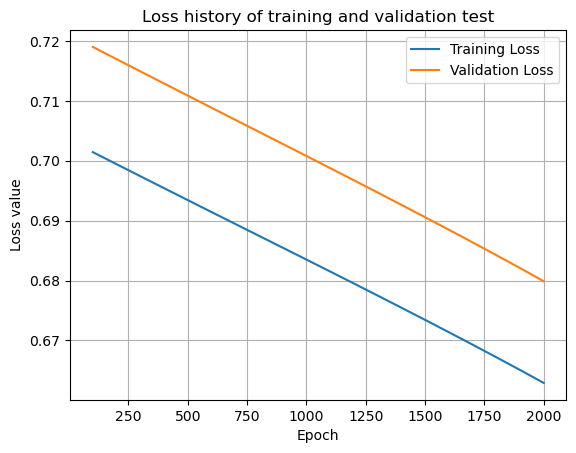

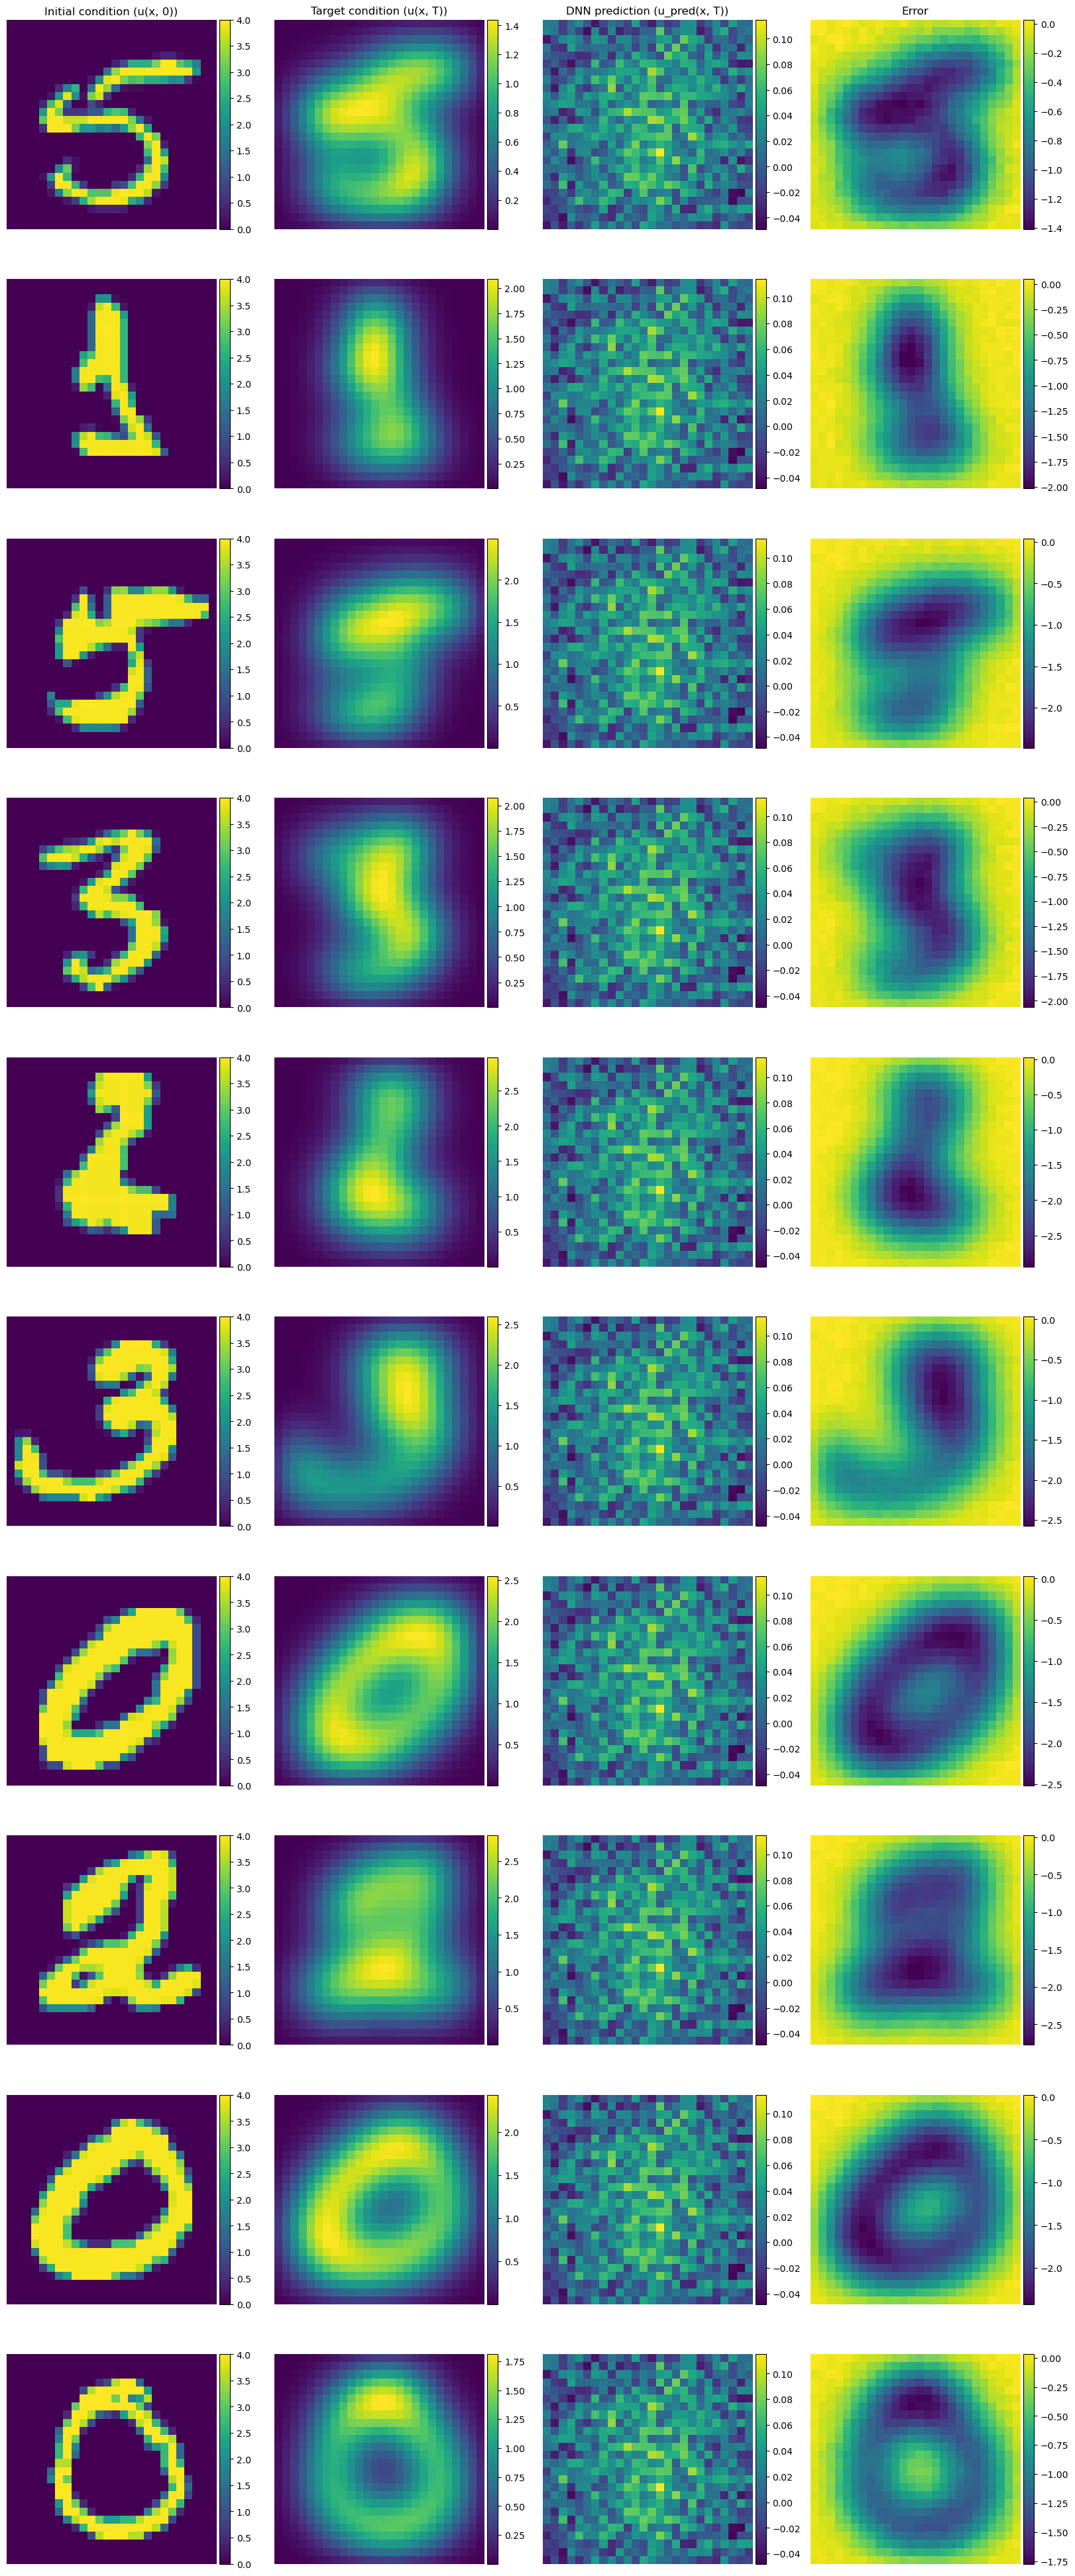

In [36]:
# write your code here...
#full batch gradient descent
model = FullyConnectedNetwork(input_dim=676, output_dim=676, n_layers=8, n_units=700, activation=torch.nn.ReLU())

optimizer_SGD = torch.optim.SGD(model.parameters(), lr=1e-3)
train_and_plot(model=model, optimizer=optimizer_SGD, max_epoches=2000, batch_size=2000)

----------------------------------------------------------------------------------------------------------
Current Optimizer is Adam
Current Epoch: 100/2000
The training loss is 0.016035154811106622
The validation loss is 0.01718681864440441
The mean relative error (in percentage) for the validation set: 15.46471881866455
Current Epoch: 200/2000
The training loss is 0.007713630213402212
The validation loss is 0.009194821119308472
The mean relative error (in percentage) for the validation set: 11.31138801574707
Current Epoch: 300/2000
The training loss is 0.004265656927600503
The validation loss is 0.005366646684706211
The mean relative error (in percentage) for the validation set: 8.641632080078125
Current Epoch: 400/2000
The training loss is 0.002628024492878467
The validation loss is 0.003452034667134285
The mean relative error (in percentage) for the validation set: 6.930775165557861
Current Epoch: 500/2000
The training loss is 0.0014880167436785996
The validation loss is 0.00249374

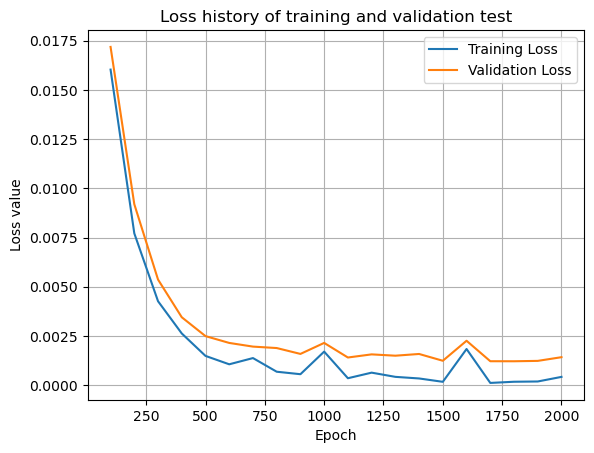

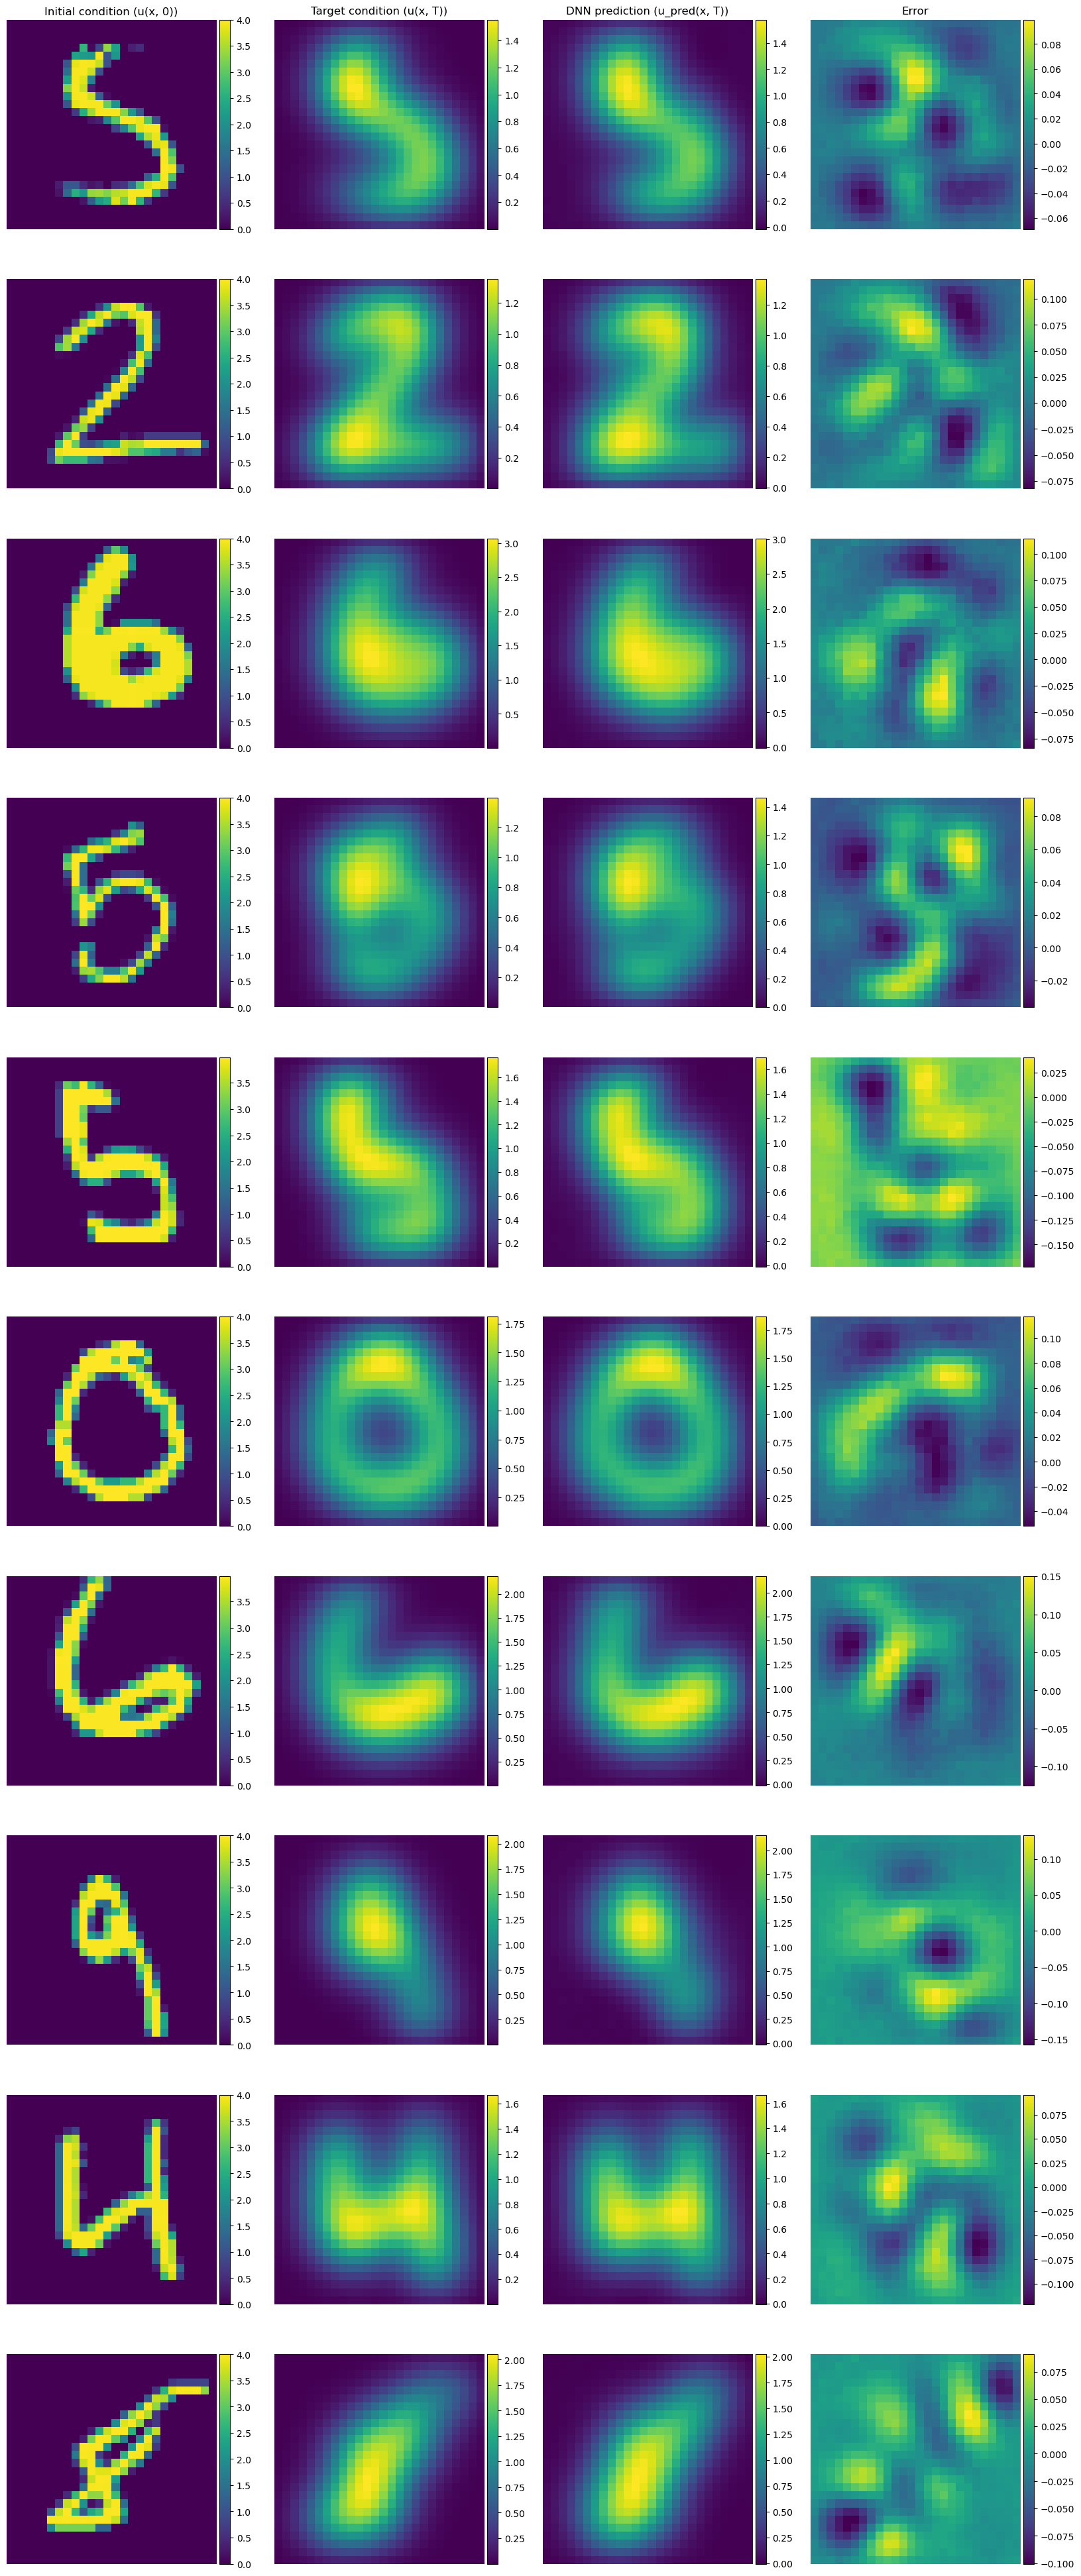

In [37]:
#Mini-batch gradient descent
optimizer_SGD = torch.optim.Adam(model.parameters(), lr=1e-3)
train_and_plot(model=model, optimizer=optimizer_SGD, max_epoches=2000, batch_size=1024)

----------------------------------------------------------------------------------------------------------
Current Optimizer is Adam
Current Epoch: 100/2000
The training loss is 0.0028331065259408206
The validation loss is 0.0027719850186258554
The mean relative error (in percentage) for the validation set: 6.210687160491943
Current Epoch: 200/2000
The training loss is 0.0010289737256243825
The validation loss is 0.0012894290266558528
The mean relative error (in percentage) for the validation set: 4.235873699188232
Current Epoch: 300/2000
The training loss is 0.0010474809096194804
The validation loss is 0.0010691647185012698
The mean relative error (in percentage) for the validation set: 3.8571503162384033
Current Epoch: 400/2000
The training loss is 0.0008209999941755086
The validation loss is 0.0009685982950031757
The mean relative error (in percentage) for the validation set: 3.6712684631347656
Current Epoch: 500/2000
The training loss is 0.0004783104777743574
The validation loss is

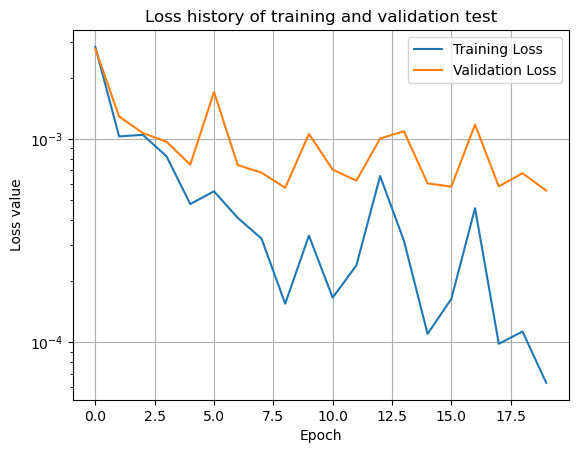

[654, 114, 25, 759, 281, 250, 228, 142, 754, 104]
(1000, 26, 26)


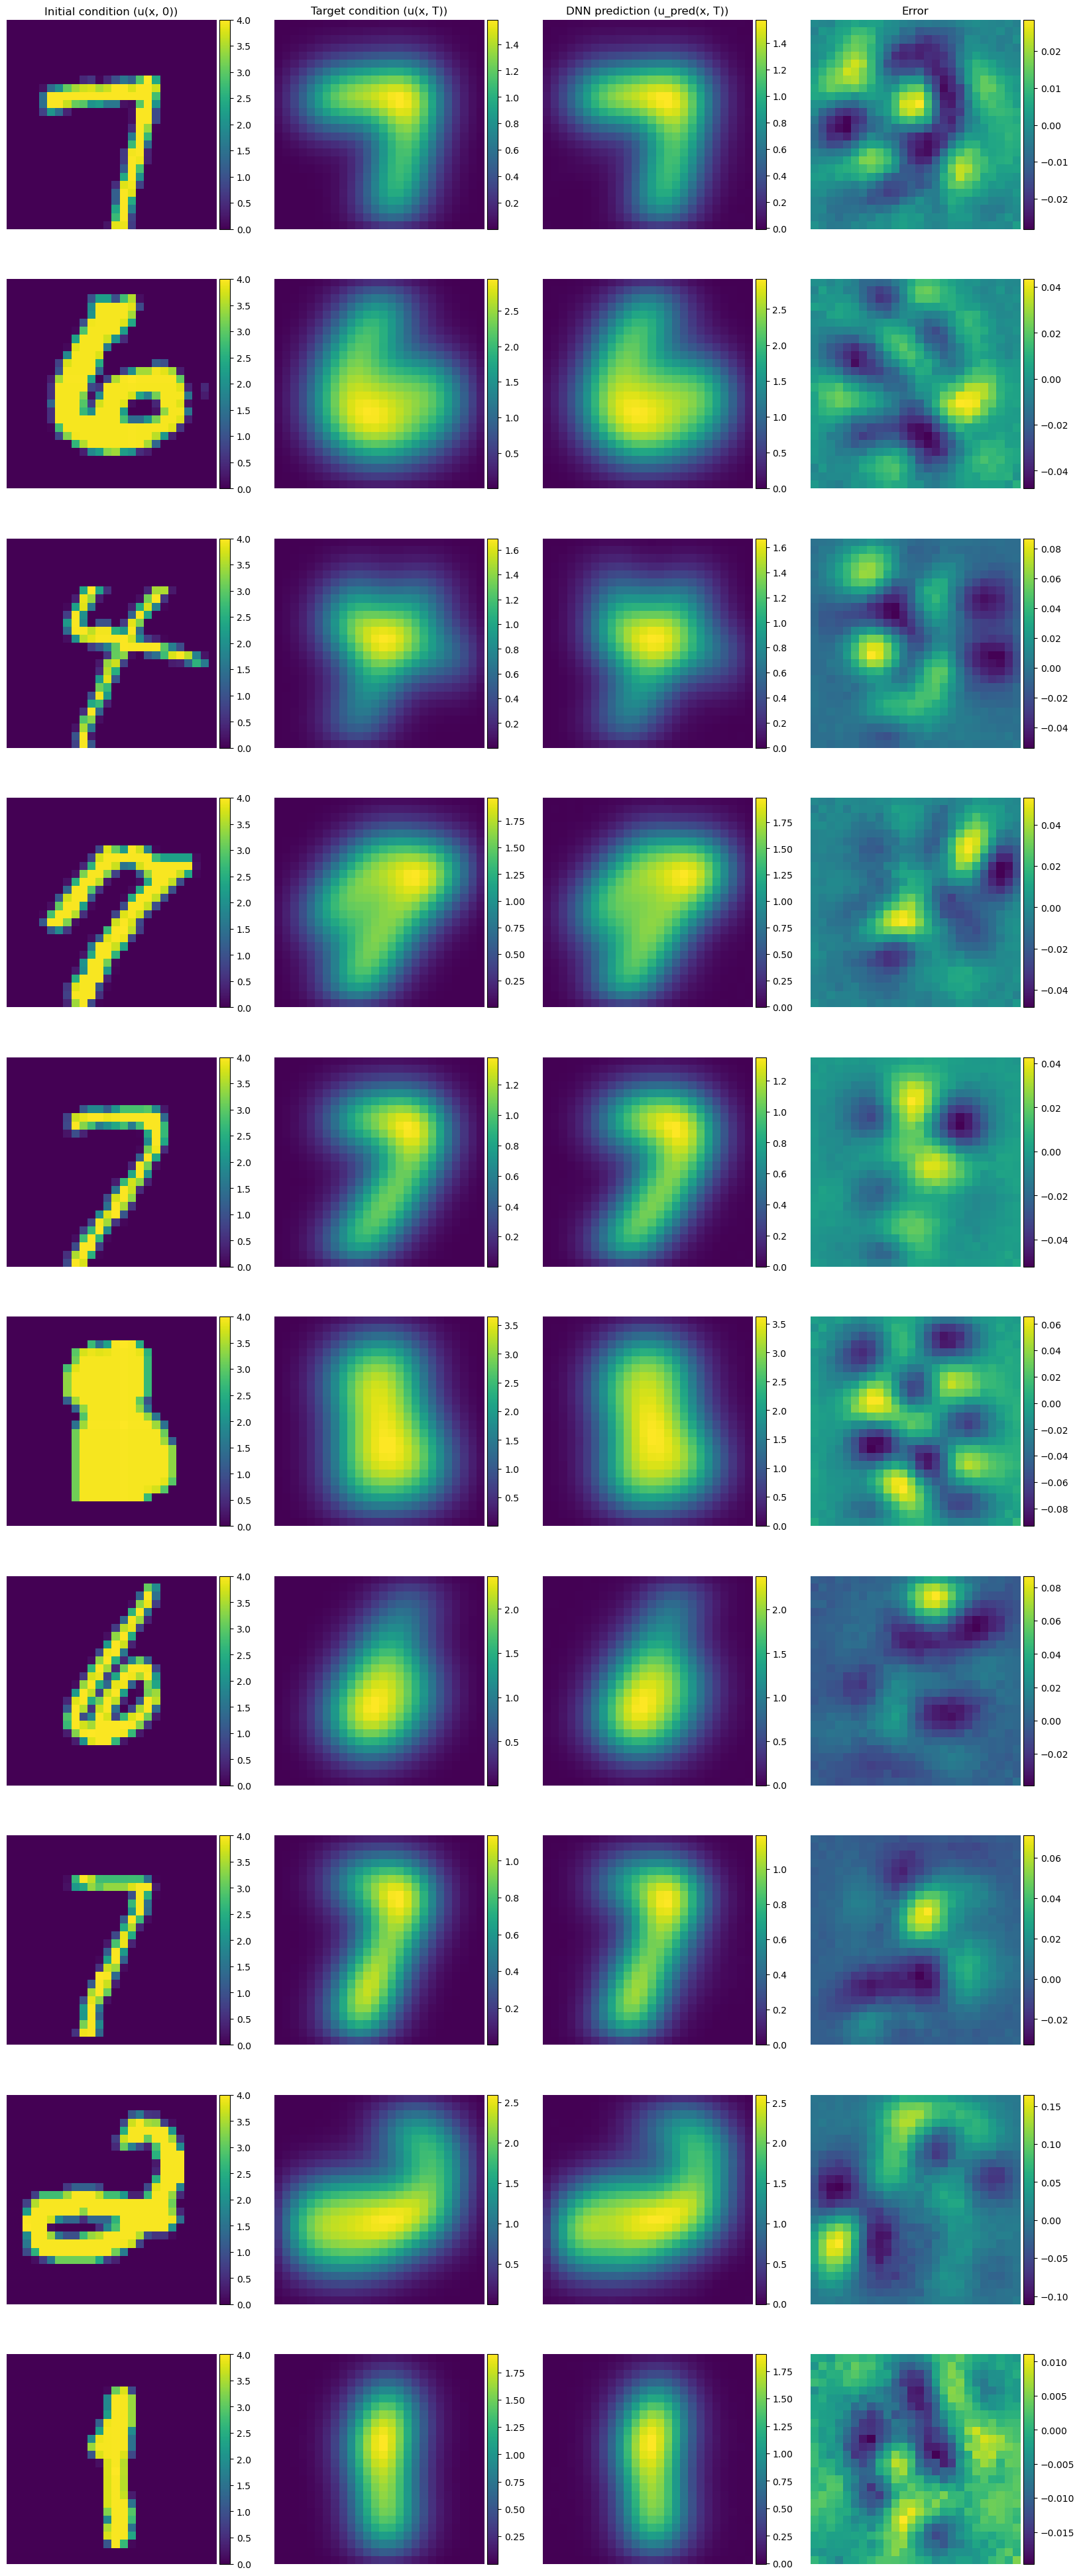

In [24]:
#Adam
optimizer_Adam = torch.optim.Adam(model.parameters(), lr=1e-3)
train_and_plot(model=model, optimizer=optimizer_Adam, max_epoches=2000, batch_size=1024)


----------------------------------------------------------------------------------------------------------
Current Optimizer is RMSprop
Current Epoch: 100/2000
The training loss is 0.011942365672439337
The validation loss is 0.010669275186955929
The mean relative error (in percentage) for the validation set: 12.184612274169922
Current Epoch: 200/2000
The training loss is 0.016751656658016145
The validation loss is 0.013380459509789944
The mean relative error (in percentage) for the validation set: 13.645195960998535
Current Epoch: 300/2000
The training loss is 0.010045920964330435
The validation loss is 0.009821586310863495
The mean relative error (in percentage) for the validation set: 11.690553665161133
Current Epoch: 400/2000
The training loss is 0.0063792208675295115
The validation loss is 0.010991882532835007
The mean relative error (in percentage) for the validation set: 12.367454528808594
Current Epoch: 500/2000
The training loss is 0.0023254886618815362
The validation loss is 0

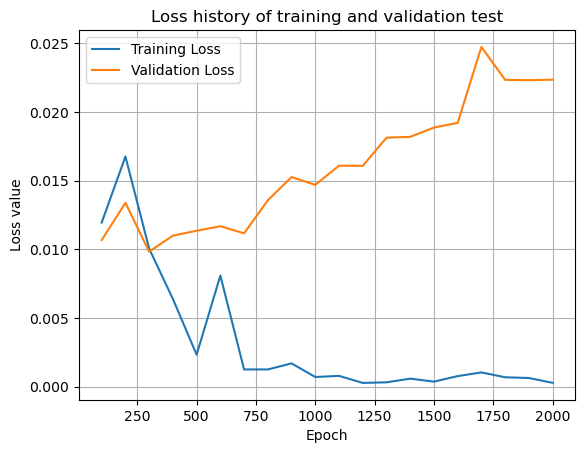

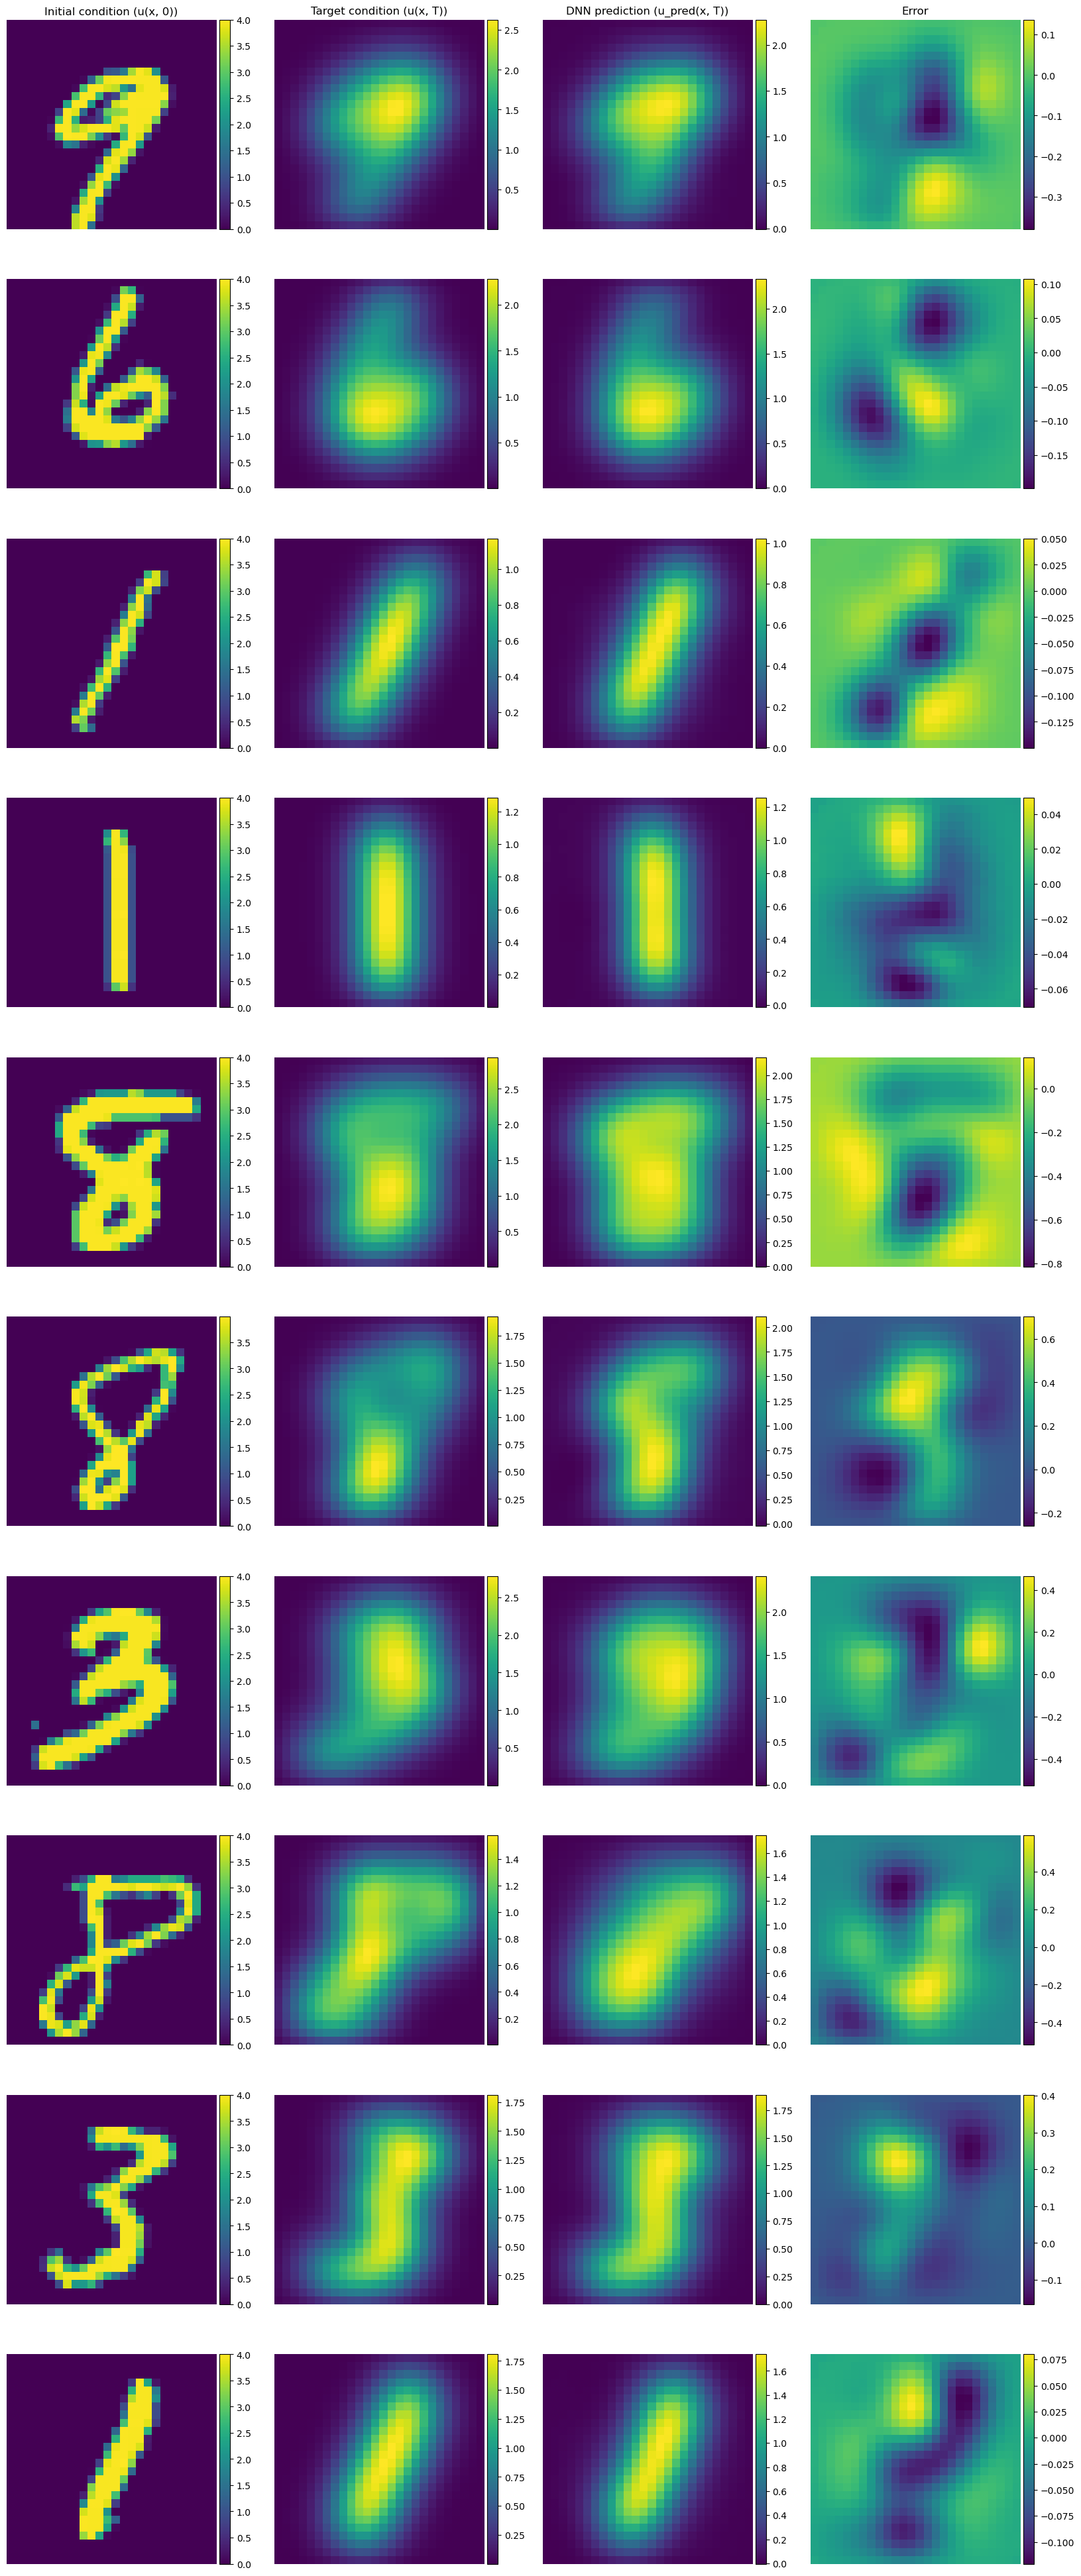

In [38]:
#RMSprop
optimizer_RMSprop = torch.optim.RMSprop(model.parameters(), lr=1e-3)
train_and_plot(model=model, optimizer=optimizer_RMSprop, max_epoches=2000, batch_size=1024)

Use this text cell to: comment on your observations. Which optimizer performs best? Which criteria are you using to
judge the relative performance of different optimizers and reach at your conclusion.

## Q5: Tuning learning rate for the optimal optimizer (learning_rate=[1e-5, 1e-2, 1])

In [21]:
# write your code here...

Use this text cell to: comment on your observations. Which learning rate performs best? Which criteria are you using to
judge the relative performance? Why do you think the specific value of learning rate performed better compared to other two.

